In [28]:
import pandas as pd
import numpy as np
import datetime
import nltk

from nltk import word_tokenize

import matplotlib.pyplot as plt
import matplotlib.cm as cm #color maps
import seaborn as sns

from IPython.display import display, clear_output

from collections import defaultdict, Counter

A lot of this is poached from jv-features for practice in adding my own features of excess capitals and question mark clues

In [29]:
"""
Functions
"""

def hint_length(s, ignore=None):
    """ determines length of hint, either with all characters or minus special characters"""
    if ignore == None:
        return len(s)
    try:
        ignore[0]
        l = len(s)
        for char in ignore:
            l = l - s.count(char)
        return l
    except IndexError:
        return len(s)-s.count(ignore)     

def num_one_word_hints(hlist):
    """ Returns number of one word hints from the list of hints for a puzzle"""
    num = 0
    for hint in hlist:
        if hint.count(' ') == 0:
            num += 1
    return num

def num_caps(string):
    #will return number of capital letters, not including spaces or first character, in a string
    count=int(0)
    for a in string:
        if a==string[0]:
            count +=0
        elif (a.isupper()) == True: 
            count+= 1
    return count

def is_wp(string):
    if string.endswith('?')== True:
        return 1
    else:
        return 0
    

def make_xword_feats(df):
    """Operates on crossword puzzle hints csv file from HTML scraper"""
    # convert year/month/day columns to single pd.datetime64 column. not needed for jv-xword-full.csv
    df['date'] = df['date'].apply(pd.to_datetime)
    
    # Block density = fraction of board used for answers
    df['BlockDensity'] = (df['NumBlocks'] / (df['NumRows'] * df['NumCols']))*100
    
    # length of hint minus special characters
    df['HintLength']   = df['Hint'].apply(hint_length, args=([['-', "\""]]))
    
    # answer length, no special characters
    df['AnswerLength'] = df['Answer'].str.len()
    
    #number of capitals
    df['Capitals'] = df['Hint'].apply(num_caps)
    
    df['WordPlay'] = df['Hint'].apply(is_wp)
    
    return df



In [3]:
"""
Load crossword puzzle hints from scraped HTML
""" 

xword = pd.read_csv("jv-xword-full.csv", converters={'Answer' : str, 'Hint' : str}, encoding='latin-1')
xword = make_xword_feats(xword)


In [4]:
xword.head(50)

,date,Weekday,Direction,Line,Hint,Answer,Author,Editor,PuzTitle,PuzClue,NumRows,NumCols,NumWords,NumBlocks,MissingLetters,BlockDensity,HintLength,AnswerLength,Capitals,WordPlay
0,2020-12-31,Thursday,Across,1,N.B.A. stat,PPG,David J. Kahn,Will Shortz,"New York Times, Thursday, December 31, 2020",Local economy makeup ... or a hint to this puz...,15,15,70,40,NaN,17.777778,11,3,2,0
1,2020-12-31,Thursday,Across,4,Number of stripes on la bandera mexicana,TRES,David J. Kahn,Will Shortz,"New York Times, Thursday, December 31, 2020",Local economy makeup ... or a hint to this puz...,15,15,70,40,NaN,17.777778,40,4,0,0
2,2020-12-31,Thursday,Across,8,Relay; e.g.,EVENT,David J. Kahn,Will Shortz,"New York Times, Thursday, December 31, 2020",Local economy makeup ... or a hint to this puz...,15,15,70,40,NaN,17.777778,11,5,0,0
3,2020-12-31,Thursday,Across,13,"Oscar-winning actor for ""Moonlight"" and ""Green...",ALI,David J. Kahn,Will Shortz,"New York Times, Thursday, December 31, 2020",Local economy makeup ... or a hint to this puz...,15,15,70,40,NaN,17.777778,47,3,3,0
4,2020-12-31,Thursday,Across,14,Chew (out),REAM,David J. Kahn,Will Shortz,"New York Times, Thursday, December 31, 2020",Local economy makeup ... or a hint to this puz...,15,15,70,40,NaN,17.777778,10,4,0,0
5,2020-12-31,Thursday,Across,15,"Actress Clarke of ""Game of Thrones""",EMILIA,David J. Kahn,Will Shortz,"New York Times, Thursday, December 31, 2020",Local economy makeup ... or a hint to this puz...,15,15,70,40,NaN,17.777778,33,6,3,0
6,2020-12-31,Thursday,Across,16,Rapper MC ___,REN,David J. Kahn,Will Shortz,"New York Times, Thursday, December 31, 2020",Local economy makeup ... or a hint to this puz...,15,15,70,40,NaN,17.777778,13,3,2,0
7,2020-12-31,Thursday,Across,17,Plant that lacks true roots and leaves,ALGA,David J. Kahn,Will Shortz,"New York Times, Thursday, December 31, 2020",Local economy makeup ... or a hint to this puz...,15,15,70,40,NaN,17.777778,38,4,0,0
8,2020-12-31,Thursday,Across,18,Be surpassed by,LOSETO,David J. Kahn,Will Shortz,"New York Times, Thursday, December 31, 2020",Local economy makeup ... or a hint to this puz...,15,15,70,40,NaN,17.777778,15,6,0,0
9,2020-12-31,Thursday,Across,19,Broker's request for funds,MARGINCALL,David J. Kahn,Will Shortz,"New York Times, Thursday, December 31, 2020",Local economy makeup ... or a hint to this puz...,15,15,70,40,NaN,17.777778,26,10,0,0


In [34]:

xword_uniques = xword.groupby(['date'])['Answer'].apply(list).reset_index().copy()

ans_dict = defaultdict(list)

# build a dictionary with answers for keys and puzzles for values
for index, row in xword_uniques.iterrows():
    for ans in row['Answer']:
        ans_dict[ans].append(index)

# find all keys mapped to only one puzzle
unique_ans = [hint for hint, pz in ans_dict.items() if len(pz) == 1]

# take the intersection of a puzzle's answers with the unique answer set (applied below)
def get_unique_clues(row):
    return list(set(row).intersection(set(unique_ans)))

# Adds a column that says how many other puzzles have this answer
xword['OtherPuzAns'] = xword['Answer'].apply(lambda x: len(ans_dict[x]))

In [35]:
# function for counting number of clues containing an excess capital letter

def has_prop_noun(capitals):
    count=0
    for i in capitals:
        if i>0:
            count+= 1
    return count

In [36]:
df = xword.groupby(['date', 'Weekday'])[['Hint', 'HintLength', 'Answer', 'AnswerLength', 'OtherPuzAns', 'BlockDensity','Capitals','WordPlay']].agg(list).reset_index()

df

,date,Weekday,Hint,HintLength,Answer,AnswerLength,OtherPuzAns,BlockDensity,Capitals,WordPlay
0,1994-01-01,Saturday,"[Hunt, Dos follow, Asseveration, When the ghos...","[4, 10, 12, 32, 17, 4, 19, 28, 15, 21, 20, 15,...","[STALK, PASSOS, STATING, ACTONE, CASHMERE, REP...","[5, 6, 7, 6, 8, 6, 3, 7, 3, 4, 5, 4, 5, 3, 5, ...","[20, 3, 6, 25, 2, 13, 162, 14, 18, 86, 38, 45,...","[16.88888888888889, 16.88888888888889, 16.8888...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1994-01-02,Sunday,"[Pops, Cards left over from a deal, Invited a ...","[4, 27, 17, 14, 15, 12, 28, 9, 18, 23, 18, 19,...","[SODAS, TALON, SPED, BRED, ATRIA, SONATA, ARNO...","[5, 5, 4, 4, 5, 6, 4, 4, 13, 9, 3, 7, 4, 6, 6,...","[55, 51, 128, 37, 110, 30, 134, 85, 1, 1, 41, ...","[20.03780718336484, 20.03780718336484, 20.0378...","[0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, ...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1994-01-03,Monday,"[Gore's ""___ in the Balance"", One who's ""agin""...","[25, 17, 10, 29, 22, 9, 20, 3, 17, 14, 13, 7, ...","[EARTH, ANTI, CAR, AROOM, LEAN, AREA, STARSEAR...","[5, 4, 3, 5, 4, 4, 10, 4, 4, 5, 4, 3, 6, 5, 5,...","[57, 292, 159, 30, 84, 515, 2, 55, 91, 26, 284...","[18.666666666666668, 18.666666666666668, 18.66...","[1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 5, 2, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1994-01-04,Tuesday,"[Rumble, Not fancy?, Difficult obligation, ""__...","[6, 10, 20, 15, 23, 19, 13, 18, 7, 4, 14, 13, ...","[MELEE, FACT, TASK, ACASE, AMOR, ARLO, THICKJU...","[5, 4, 4, 5, 4, 4, 15, 4, 4, 5, 3, 3, 15, 5, 5...","[74, 39, 49, 9, 141, 204, 1, 80, 105, 26, 75, ...","[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16....","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1994-01-05,Wednesday,"[Noodlehead, Dagger handles, Silver-tongued, E...","[10, 14, 13, 19, 25, 13, 31, 17, 9, 26, 11, 18...","[DOLT, HAFTS, GLIB, ONEA, ALLAH, REMO, CANTERB...","[4, 5, 4, 4, 5, 4, 10, 4, 4, 5, 3, 4, 6, 6, 6,...","[39, 10, 45, 168, 73, 41, 1, 79, 98, 15, 294, ...","[16.88888888888889, 16.88888888888889, 16.8888...","[0, 0, 0, 0, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...
9752,2020-12-27,Sunday,"[Venomous snake, ""To be honest ..."", ""My goodn...","[14, 16, 12, 52, 39, 14, 21, 26, 12, 11, 22, 1...","[MAMBA, FACTIS, ISAY, MOA, ABOIL, IDUNNO, NOTE...","[5, 6, 4, 3, 5, 6, 4, 3, 12, 8, 4, 6, 4, 4, 5,...","[22, 2, 75, 39, 42, 17, 107, 305, 1, 3, 181, 1...","[17.233560090702948, 17.233560090702948, 17.23...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
9753,2020-12-28,Monday,"[Health resorts, Georgia fruit, Tuxedo shirt f...","[14, 13, 21, 13, 24, 25, 21, 39, 21, 24, 7, 8,...","[SPAS, PEACH, STUD, EACH, EMCEE, AONE, NAME, A...","[4, 5, 4, 4, 5, 4, 4, 5, 4, 6, 8, 5, 5, 3, 3, ...","[129, 19, 68, 99, 80, 175, 102, 175, 85, 9, 3,...","[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16....","[0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9754,2020-12-29,Tuesday,"[Salacious, Opposite of loose, Galileo; by bir...","[9, 17, 17, 8, 14, 17, 13, 40, 12, 15, 23, 35,...","[LEWD, TAUT, PISAN, ALOE, RIME, UNTIE, WARRIOR...","[4, 4, 5, 4, 4, 5, 15, 3, 6, 4, 3, 7, 12, 4, 3...","[42, 64, 21, 397, 42, 60, 1, 190, 1, 47, 138, ...","[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9755,2020-12-30,Wednesday,"[Discovery, First courses; for short, SAG-___ ...","[9, 24, 26, 37, 10, 13, 6, 25, 23, 35, 4, 55, ...","[FIND, APPS, AFTRA, OCEANVIEW, CORER, RAWSIENN...","[4, 4, 5, 9, 5, 9, 5, 3, 11, 3, 3, 6, 4, 4, 4,...","[10, 46, 16, 1, 20, 1, 123, 414, 4, 44, 118, 4...","[15.11111111111111, 15.11111111111111, 15.1111...","[0, 0, 2, 0,

In [125]:
features = df.copy()

features['AvgHintLength'] = df['HintLength'].apply(np.mean)

features['AvgAnswerLength'] = df['AnswerLength'].apply(np.mean)

features['NumHints'] = df['Hint'].apply(len)

features['NumOneWordHints'] = df['Hint'].apply(num_one_word_hints)

features['OtherPuzAns'] = df['OtherPuzAns'].apply(sum)

features['BlockDensity'] = df['BlockDensity'].apply(np.mean)

# Monday is 0
# Sunday is 6
features['WeekdayNum'] = df['date'].dt.dayofweek

features['TotalCapitals'] = df['Capitals'].apply(sum)

features['ProperNounClues'] = df['Capitals'].apply(has_prop_noun)
#percent Proper Noun Clues#
features['PctPNC'] = 100*features['ProperNounClues']/features['NumHints']

features['WordPlay'] = df['WordPlay'].apply(sum)

features['PctWP'] = 100*features['WordPlay']/features['NumHints']


In [126]:
features

,date,Weekday,Hint,HintLength,Answer,AnswerLength,OtherPuzAns,BlockDensity,Capitals,WordPlay,AvgHintLength,AvgAnswerLength,NumHints,NumOneWordHints,WeekdayNum,TotalCapitals,ProperNounClues,PctPNC,PctWP
0,1994-01-01,Saturday,"[Hunt, Dos follow, Asseveration, When the ghos...","[4, 10, 12, 32, 17, 4, 19, 28, 15, 21, 20, 15,...","[STALK, PASSOS, STATING, ACTONE, CASHMERE, REP...","[5, 6, 7, 6, 8, 6, 3, 7, 3, 4, 5, 4, 5, 3, 5, ...",3093,16.888889,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, ...",3,14.969697,5.666667,66,15,5,15,12,18.181818,4.545455
1,1994-01-02,Sunday,"[Pops, Cards left over from a deal, Invited a ...","[4, 27, 17, 14, 15, 12, 28, 9, 18, 23, 18, 19,...","[SODAS, TALON, SPED, BRED, ATRIA, SONATA, ARNO...","[5, 5, 4, 4, 5, 6, 4, 4, 13, 9, 3, 7, 4, 6, 6,...",11874,20.037807,"[0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, ...",11,15.547059,4.976471,170,33,6,52,35,20.588235,6.470588
2,1994-01-03,Monday,"[Gore's ""___ in the Balance"", One who's ""agin""...","[25, 17, 10, 29, 22, 9, 20, 3, 17, 14, 13, 7, ...","[EARTH, ANTI, CAR, AROOM, LEAN, AREA, STARSEAR...","[5, 4, 3, 5, 4, 4, 10, 4, 4, 5, 4, 3, 6, 5, 5,...",6770,18.666667,"[1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 5, 2, 0, 0, 0, ...",2,13.368421,4.815789,76,16,0,32,20,26.315789,2.631579
3,1994-01-04,Tuesday,"[Rumble, Not fancy?, Difficult obligation, ""__...","[6, 10, 20, 15, 23, 19, 13, 18, 7, 4, 14, 13, ...","[MELEE, FACT, TASK, ACASE, AMOR, ARLO, THICKJU...","[5, 4, 4, 5, 4, 4, 15, 4, 4, 5, 3, 3, 15, 5, 5...",6572,16.000000,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,14.602564,4.846154,78,13,1,20,16,20.512821,6.410256
4,1994-01-05,Wednesday,"[Noodlehead, Dagger handles, Silver-tongued, E...","[10, 14, 13, 19, 25, 13, 31, 17, 9, 26, 11, 18...","[DOLT, HAFTS, GLIB, ONEA, ALLAH, REMO, CANTERB...","[4, 5, 4, 4, 5, 4, 10, 4, 4, 5, 3, 4, 6, 6, 6,...",6352,16.888889,"[0, 0, 0, 0, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, ...",1,13.312500,4.675000,80,24,2,25,18,22.500000,1.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9752,2020-12-27,Sunday,"[Venomous snake, ""To be honest ..."", ""My goodn...","[14, 16, 12, 52, 39, 14, 21, 26, 12, 11, 22, 1...","[MAMBA, FACTIS, ISAY, MOA, ABOIL, IDUNNO, NOTE...","[5, 6, 4, 3, 5, 6, 4, 3, 12, 8, 4, 6, 4, 4, 5,...",10639,17.233560,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, ...",6,22.297101,5.289855,138,8,6,68,32,23.188406,4.347826
9753,2020-12-28,Monday,"[Health resorts, Georgia fruit, Tuxedo shirt f...","[14, 13, 21, 13, 24, 25, 21, 39, 21, 24, 7, 8,...","[SPAS, PEACH, STUD, EACH, EMCEE, AONE, NAME, A...","[4, 5, 4, 4, 5, 4, 4, 5, 4, 6, 8, 5, 5, 3, 3, ...",6200,16.000000,"[0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 1, 0, ...",1,21.333333,4.846154,78,4,0,61,30,38.461538,1.282051
9754,2020-12-29,Tuesday,"[Salacious, Opposite of loose, Galileo; by bir...","[9, 17, 17, 8, 14, 17, 13, 40, 12, 15, 23, 35,...","[LEWD, TAUT, PISAN, ALOE, RIME, UNTIE, WARRIOR...","[4, 4, 5, 4, 4, 5, 15, 3, 6, 4, 3, 7, 12, 4, 3...",6977,16.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...",1,21.653846,4.846154,78,8,1,34,21,26.923077,1.282051
9755,2020-12-30,Wednesday,"[Discovery, First courses; for short, SAG-___ ...","[9, 24, 26, 37, 10, 13, 6, 25, 23, 35, 4, 55, ...","[FIND, APPS, AFTRA, OCEANVIEW, CORER, RAWSIENN...","[4, 4, 5, 9, 5, 9, 5, 3, 11, 3, 3, 6, 4, 4, 4,...",6170,15.111111,"[0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 3, 0, 0, 0, ...",3,20.459459,5.162162,74,12,2,44,24,32.432432,4.054054


In [143]:
features.to_csv('cc-features.csv', index=False, columns = ['date', 'Weekday', 'WeekdayNum', 'AvgHintLength', 'AvgAnswerLength', 'NumHints', 'NumOneWordHints', 'BlockDensity', 'OtherPuzAns', 'PctPNC','PctWP'])

In [127]:
features.groupby('Weekday')['PctWP'].mean().sort_values(ascending=False).reset_index().head(10)

,Weekday,PctWP
0,Sunday,5.351112
1,Saturday,5.116060
2,Friday,4.910152
3,Thursday,4.265906
4,Wednesday,3.505338
5,Tuesday,2.274626
6,Monday,1.133835


In [1]:
block_data = features.groupby(['Weekday'])['PctWP'].agg([np.mean, np.std, list]).reset_index()
block_data
block_data.sort_values(by='mean', ascending=True, inplace=True)

NameError: name 'features' is not defined

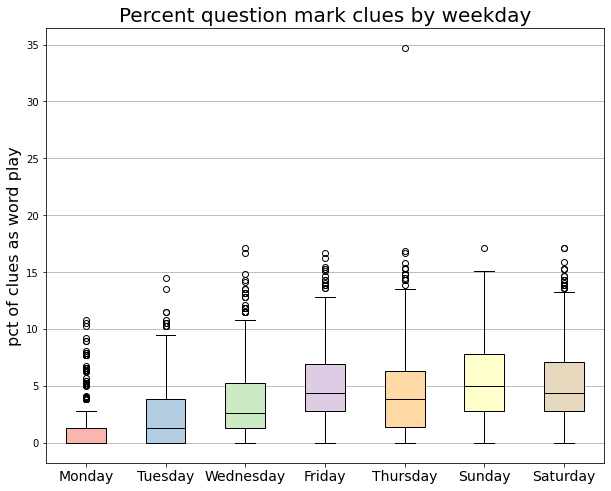

In [135]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
bplot = ax.boxplot(block_data['list'],patch_artist=True, medianprops=dict(color='black'))
ax.set_xticklabels(block_data['Weekday'].tolist(),fontsize=14)
ax.set_ylabel('pct of clues as word play',fontsize=16)
ax.set_title('Percent question mark clues by weekday',fontsize=20)
ax.grid(True,axis='y')

cmap = cm.get_cmap('Pastel1')

for patch, color in zip(bplot['boxes'], cmap.colors):
    patch.set_facecolor(color)
#plt.savefig(fname="density")
plt.show()

In [137]:
block_data2 = features.groupby(['Weekday'])['PctPNC'].agg([np.mean, np.std, list]).reset_index()

block_data2.sort_values(by='std', ascending=True, inplace=True)
block_data2

,Weekday,mean,std,list
3,Sunday,27.103376,5.302841,"[20.58823529411765, 27.142857142857142, 18.840..."
0,Friday,24.884818,6.298815,"[24.358974358974358, 25.714285714285715, 24.32..."
2,Saturday,24.820177,6.347932,"[18.181818181818183, 24.358974358974358, 28.57..."
1,Monday,27.005556,6.645794,"[26.31578947368421, 24.285714285714285, 22.972..."
4,Thursday,26.948433,6.681048,"[23.076923076923077, 24.358974358974358, 34.21..."
5,Tuesday,28.313531,6.890059,"[20.512820512820515, 23.076923076923077, 33.78..."
6,Wednesday,27.536547,7.063235,"[22.5, 34.61538461538461, 25.641025641025642, ..."


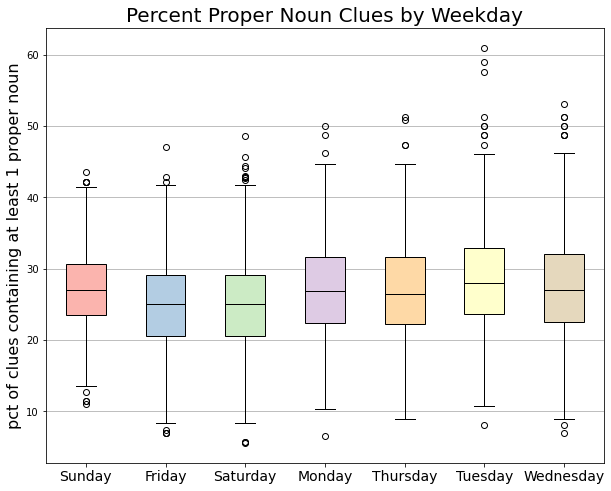

In [139]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
bplot = ax.boxplot(block_data2['list'],patch_artist=True, medianprops=dict(color='black'))
ax.set_xticklabels(block_data2['Weekday'].tolist(),fontsize=14)
ax.set_ylabel('pct of clues containing at least 1 proper noun',fontsize=16)
ax.set_title('Percent Proper Noun Clues by Weekday',fontsize=20)
ax.grid(True,axis='y')

cmap = cm.get_cmap('Pastel1')

for patch, color in zip(bplot['boxes'], cmap.colors):
    patch.set_facecolor(color)
#plt.savefig(fname="density")
plt.show()

In [ ]:
#df_features = df_features.merge(perplex_pcts[['Date','PctPerplex']], on='Date')

In [97]:
def remove_cap(string):
    if string == '':
        return
    return str(string[0].lower()+string[1:len(string)])

remove_cap(xword['Hint'][54])


In [54]:
xword['PropNoun']= xword['Hint']

In [100]:
#uncomment this if you like to watch paint dry

#for i in range(len(xword)):
#    if xword['Hint'][i] == "":
#         xword['PropNoun'][i]=0
#     else:
#         text = remove_cap(xword['Hint'][i])
#         text2=word_tokenize(text)
#         pos=nltk.pos_tag(text2)
#         count=0
#         for j in range(len(pos)):
#             if pos[j][1]=='NNP':
#                 count+=1
#             elif pos[j][1]=='NNPS':
#                 count+=1
#         xword['PropNoun'][i]=count

<ipython-input-100-d6aa1f82ba00>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xword['PropNoun'][i]=count
<ipython-input-100-d6aa1f82ba00>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xword['PropNoun'][i]=0


KeyboardInterrupt: 

In [102]:
xword.sample(100)


,date,Weekday,Direction,Line,Hint,Answer,Author,Editor,PuzTitle,PuzClue,...,NumWords,NumBlocks,MissingLetters,BlockDensity,HintLength,AnswerLength,Capitals,WordPlay,PropNoun,OtherPuzAns
443680,2005-12-08,Thursday,Down,30,Direct elsewhere,REFER,David Pringle,Will Shortz,"New York Times, Thursday, December 8, 2005","Line C, maybe, in a voting booth: Abbr.",...,78,40,NaN,17.777778,16,5,0,0,Direct elsewhere,49
764993,1994-12-05,Monday,Across,15,"""___ Smile"" (1976 Hall & Oates hit)",SARA,Sidney L. Robbins,Will Shortz,"New York Times, Monday, December 5, 1994","""___ Smile"" (1976 Hall & Oates hit)",...,78,38,FJKQXZ,16.888889,33,4,3,0,"""___ Smile"" (1976 Hall & Oates hit)",144
688583,1997-07-08,Tuesday,Across,24,"""O Sole ___""",MIO,Stephanie Spadaccini,Will Shortz,"New York Times, Tuesday, July 8, 1997","90's group with the hit ""Killing Me Softly,"" w...",...,80,38,JQZ,16.888889,10,3,2,0,"""O Sole ___""",37
743253,1995-09-13,Wednesday,Down,5,Parthenon site,ATHENS,Eileen Lexau,Will Shortz,"New York Times, Wednesday, September 13, 1995","Cary of ""Bram Stoker's Dracula""",...,74,32,JQXZ,14.222222,14,6,0,0,Parthenon site,24
706518,1996-12-05,Thursday,Down,22,Cavort,PLAY,B. Jorgensen,Will Shortz,"New York Times, Thursday, December 5, 1996",Start of a quip concerning a Hitchcock film,...,74,32,JKQXZ,14.222222,6,4,0,0,Cavort,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151034,2015-12-14,Monday,Across,30,Commence,START,Timothy Polin,Will Shortz,"New York Times, Monday, December 14, 2015",Title held by the people who lent their names ...,...,74,34,JQXZ,15.111111,8,5,0,0,Commence,64
458324,2005-03-21,Monday,Across,20,Short-lived success,ONEHITWONDER,Mike Torch,Will Shortz,"New York Times, Monday, March 21, 2005","Oscar winner for ""Scent of a Woman""",...,76,40,JKQVX,17.777778,18,12,0,0,Short-lived success,1
309991,2010-09-18,Saturday,Across,43,More solid,SANER,"Natan Last, Brown University '12",Will Shortz,"New York Times, Saturday, September 18, 2010","Literary captain who says ""It's better to sail...",...,70,30,JQXZ,13.333333,10,5,0,0,More solid,78
470592,2004-09-15,Wednesday,Across,30,Chest item,TOY,Alan Arbesfeld,Will Shortz,"New York Times, Wednesday, September 15, 2004","Famous rhymer of Bronx with ""thonx""",...,76,38,JQX,16.888889,10,3,0,0,Chest item,78
